##  Time Series Analysis Of The S&P 500 Index 

The following is an example of univariate time-series prediction based on the daily returns of the S&P 500 (SPY) data using an Autoregressive Moving Average (ARMA) model, with a 80-20 train/test split. The data modeled is the historical data captured from Yahoo Finance for the period from 2000-01-03 to 2019-10-18. The data set contains Open prices, High prices, Low prices, Close prices, Adjusted Close prices and Volume. It has no missing values. 

Our objective is to find a viable ARMA model and apply it to approximate the stationary data, specifically the returns derived from the adjusted close price changes. Also, while predicting the future values in the series we present concerns regarding the  forecast error measure, such as the Root of the Mean of the Square Errors (RMSE) and cross-validation. We also offer alternatives to mitigate overfiting issues, such as back-testing, multiple time-series viewpoints, and Fama–French factors.
Ultimately however, The ARMA model can be used as part of a larger strategy to peform a regression or machine learning task. 

In [1]:
# Import the relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

In [2]:
# Load the data set, S&P 500 (^SPX) downloaded from Yahoo Finance
# Pre-process 
raw_csv_data = pd.read_csv("SP500.csv") 
df_comp=raw_csv_data.copy()
df_comp.set_index("Date", inplace=True)
df_comp.describe()

,Open,High,Low,Close,AdjClose,Volume
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4.981000e+03
mean,1559.336251,1568.222094,1549.695476,1559.498333,1559.498333,3.087279e+09
std,567.858235,568.630961,566.894122,567.903559,567.903559,1.478798e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1149.099976,1157.739990,1140.130005,1149.500000,1149.500000,1.662000e+09
50%,1355.900024,1365.359985,1345.050049,1355.810059,1355.810059,3.212320e+09
75%,1965.140015,1976.670044,1955.589966,1966.969971,1966.969971,3.919240e+09
max,3024.469971,3027.979980,3014.300049,3025.860107,3025.860107,1.145623e+10


In [26]:
# Check the number of rows in the data set 
len(df_comp)

4981

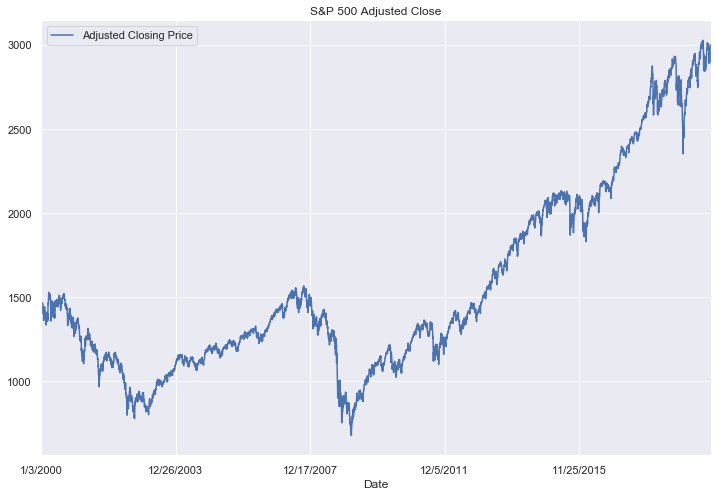

In [3]:
# Plot the AdjClose over time 
df_comp['AdjClose'].plot(legend=True, figsize=(12, 8), \
title='S&P 500 Adjusted Close', \
label='Adjusted Closing Price')


In [4]:
# Set training and test set, 80/20 split 
size = int(len(df_comp)*0.8)
df_train, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# Then get daily returns
# Focus on returns intead of price since they offer a more stationary time series data
df_train['returns'] = df_train.AdjClose.pct_change(1)*100
df_test['returns'] = df_test.AdjClose.pct_change(1)*100


In [5]:
# Delete unused columns 
del df_train['Open']
del df_train['High']
del df_train['Volume']
del df_train['Low']
del df_train['Close']

del df_test['Open']
del df_test['High']
del df_test['Volume']
del df_test['Low']
del df_test['Close']


In [6]:
df_train.describe()

,AdjClose,returns
count,3984.000000,3983.000000
mean,1323.578777,0.017308
std,315.264798,1.268639
min,676.530029,-9.034978
25%,1117.965027,-0.546984
50%,1271.500000,0.054552
75%,1452.225037,0.600310
max,2130.820068,11.580037


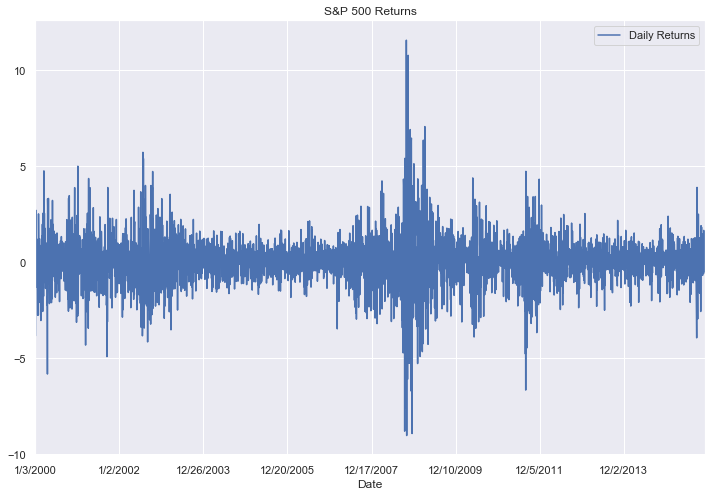

In [7]:
# Plot the returns
df_train['returns'].plot(legend=True, figsize=(12, 8), \
title='S&P 500 Returns', \
label='Daily Returns')

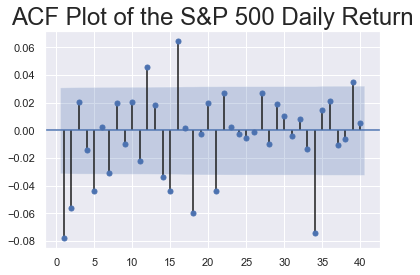

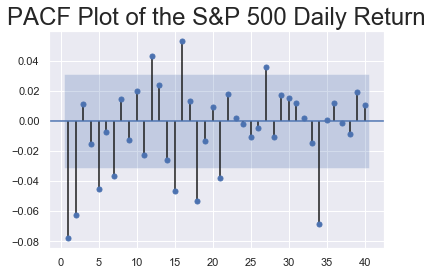

In [8]:
# We use ACF and PACF to choose a correct order for AR(p) and MA(q) features of an ARIMA model
# AR or Autoregressive: present value of the time series can be obtained using previous values of the same series.
# MA or Moving average: present value of series is a linear combination of past errors. 

# We use ACF and PACF pltos to get p and q 

# Plot the ACF graph for the returns 
# ACF is autocorrelation function  
# Auto-correlation of the series with lags of itself 
# The x axis of the ACF plot indicates the lag; the y axis the value of the correlation (bet −1 and 1)
sgt.plot_acf(df_train.returns[1:], zero = False, lags = 40)
plt.title('ACF Plot of the S&P 500 Daily Return', size=24)
plt.show()

# Plot the PACF graph for the returns 
# PACF is a partial auto-correlation function 
# Instead of finding correlation of present with lags like ACF, 
# PACF finds correlation of the residuals, thereby removings variations explained by earlier lags.
sgt.plot_pacf(df_train.returns[1:], zero = False, lags = 40)
plt.title('PACF Plot of the S&P 500 Daily Return', size=24)
plt.show()

# From ACF we get the AR order and from PACF the MA order. 
# We retain only the relevant features, so the optimal ARMA model has fewer of each type, AR and MA. 
# Too many features that are correlated can create multicollinearity issues

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 3983
Model:                     ARMA(2, 3)   Log Likelihood               -6571.982
Method:                       css-mle   S.D. of innovations              1.260
Date:                Mon, 21 Oct 2019   AIC                          13157.964
Time:                        20:23:24   BIC                          13201.993
Sample:                             0   HQIC                         13173.575
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0174      0.018      0.990      0.322      -0.017       0.052
ar.L1.returns    -1.5070      0.137    -10.964      0.000      -1.776      -1.238
ar.L2.returns    -0.5568      0.129     

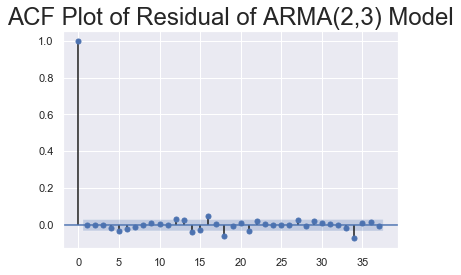

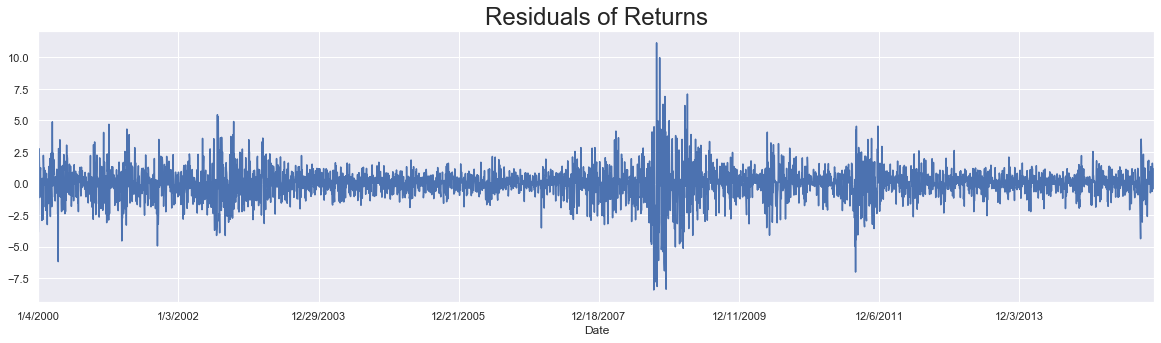

Mean of the residual is:  0.0008550410818557903
Standard Deviation of the residual is:  1.2586426708729042


In [9]:
# Match ACF with the MA order and PACF with the AR order
# We can estimate: no more than 5 lags of MA and at most 7 for AR 
# Ideally We start with over-parameterized ARMA with many lags for AR and MA 
# then decrease the lags with different models until the 3 criteria are met: 
# 1) All coefficients are significant, 2) high log likelihood, and 3) low info. criteria 

# There is a trade off between the speed of execution and accuracy of the model
# If we select a more complicated model with more AR and MA lags, accuracty will improve                                     
# but this comes at the expense of longer execution time.
# For a simpler model, choose ARMA(2,3) and for a more complicated model, select ARMA(12,12) 

# This variable determines whether we should run a simple or a complex model
model_selection =1 # 1 for a simple model and 2 for a more complicated model

if model_selection == 1:
    model_ret_ar_2_ma_3 = ARMA(df_train.returns[1:], order = (2,3))
    # start_ar_lags controls the length of the lags in fitting the model
    results_ret_ar2_ma3 = model_ret_ar_2_ma_3.fit(start_ar_lags = 12)
    print(results_ret_ar2_ma3.summary())
    final_model_result = results_ret_ar2_ma3
else:
    model_alternative = ARMA(df_train.returns[1:], order = (12,12))
    results_alternative = model_alternative.fit(start_ar_lags = 40)
    print(results_alternative.summary())
    final_model_result = results_alternative
    
# Checking for Residual
# Residuals are defined as the differences between the observed and predicted responses
# Residual Plost should show no pattern. If a pattern is observed, there may be “heteroscedasticity” in the errors 
# which means that the variance of the residuals may not be constant, likely necessitating transformation via log or sq rt.
# We can make the mistake of starting off with a model, whose order is lower than the optimal one
# Ideally, residuals should be close to white noise, randomnly scattered around zero
# A time series is white noise if the variables are independent and identically distributed with a mean of zero (i.d.d.)
# This means that all variables have the same variance and each value has a zero correlation with all other values in the series

df_train['residual'] = final_model_result.resid
resid = final_model_result.resid[1:]
sgt.plot_acf(resid)
plt.title('ACF Plot of Residual of ARMA(2,3) Model', size=24)
plt.show()

df_train.residual[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

print('Mean of the residual is: ', np.mean(resid))
print('Standard Deviation of the residual is: ', np.std(resid))

# Akaike information criterion (AIC) estimates the relative amount of info lost by a given model: 
# the less information a model loses, the higher the quality of that model
# Simpler likelihood ratio indicates how many times more likely the observed values are to occur under one model than under the other
# logarithms of those values yield a log-likelihood ratio
# Based on the results (look at p-values, AIC, and log likelihood), we select the simpler model ARMA (2,3)

In [10]:
# Prediction
# The ROOT OF THE MEAN OF THE SQUARE ERRORS (RMSE) is the standard deviation of the residuals (prediction errors)
# Residuals are a measure of how far from the regression line data points are vs. 
# RMSE is a measure of how spread out these residuals are. How concentrated the data is around the line of best fit

pred_is= final_model_result.predict()

# In Time series Forecasting, 'In-sample' means train data 'Out-sample' means test data
# By the "sample" it means the data sample that we're using to fit the model.

# Compute in-sample RMSE

rmse_insample = np.sqrt(np.mean((df_train.returns[1:] - pred_is)**2))

# Compute out of sample RMSE

pred_os=final_model_result.forecast(steps=len(df_test)-1, exog=None, alpha=0.05)[0]
rmse_outsample = np.sqrt(np.mean((df_test.returns[1:] - pred_os)**2))

print('RMSE for in-sample data is: ', rmse_insample)
print('RMSE for out-of-sample data is: ', rmse_outsample)

# There's no one acceptable threshold for RMSE, as a sizable error range may be allowed in this data set.
# We could compare the RMSE to the avg values in the test set, but 
# if our model is good the RMSE's should be similar. 
# The RMSE for in-sample is higher than out-sample's, hinting at overfiting issues 

# Overfiting in a time series can be mitigated but not through cross-validation due to autocorrelation 
# Autocorrelations mean that data points are not independent from each other across time, so holding out some data points 
# from the training set doesn’t necessarily remove all their associated information. 
# Further, time series models contain autoregressive components, with equally spaced data points. 
# If we leave out random subsets of the data, the training and testing sets will have holes that destroy the autoregressive components

# So we can at best approximate cross-validation by using data prior to some randomly selected point in time 
# as the training set and data after that as the testing set. Alternatively, perform extensive back-testing by splitting 
# the nput dataset over hundreds of incremental date thresholds and re-train the models' performance assesed 
# over not just over a single time-series, but over well-defined clusters of time-series. 

# Finally, for stock index time series data Fama–French factor Models may offer better predictive accuracy than said alternatives  



RMSE for in-sample data is:  1.2599640395530425
RMSE for out-of-sample data is:  0.8326603248151435


In [12]:
# In-Sample
frame_insample = {'Actual Returns': df_train.returns[1:], 'Predicted Returns': pred_is}
df_insample = pd.DataFrame(frame_insample)

# Out-of-Sample
pred_os_series = pd.Series(pred_os, index = df_test[1:].index)

frame_outsample = {'Actual Returns': df_test.returns[1:], 'Predicted Returns': pred_os_series}
df_outsample = pd.DataFrame(frame_outsample)



Text(0.5, 1.0, 'In-Sample: Actual vs. Predicted S&P 500 Daily Returns')

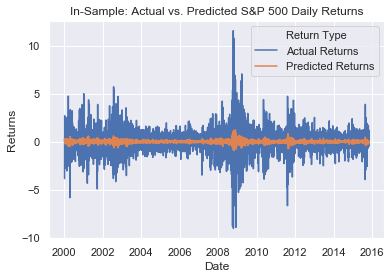

In [13]:
# plotting seaborn lineplot for in-sample data
df_insample['Date'] = df_insample.index
df_insample_long = pd.melt(df_insample, id_vars=['Date'], var_name='Return Type', value_name='Returns')

df_insample_long['Date']=pd.to_datetime(df_insample_long['Date'])
sns.lineplot(x="Date", y="Returns", hue = "Return Type", data = df_insample_long ).set_title('In-Sample: Actual vs. Predicted S&P 500 Daily Returns')



Text(0.5, 1.0, 'Out-Of-Sample: Actual vs. Predicted S&P 500 Daily Returns')

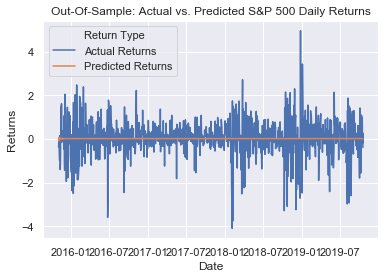

In [14]:
# Plot a seaborn lineplot for out-of-sample data
df_outsample['Date'] = df_outsample.index
df_outsample_long = pd.melt(df_outsample, id_vars=['Date'], var_name='Return Type', value_name='Returns')

df_outsample_long['Date']=pd.to_datetime(df_outsample_long['Date'])
sns.lineplot(x="Date", y="Returns", hue = "Return Type", data = df_outsample_long ).set_title('Out-Of-Sample: Actual vs. Predicted S&P 500 Daily Returns')
